# Exercise 5 - BLOB Analysis

In [1]:
from skimage import io, color, morphology
from skimage.util import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu
from skimage import segmentation
from skimage import measure
from skimage.color import label2rgb

In [2]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

## LEGO Classification

### Exercise 1

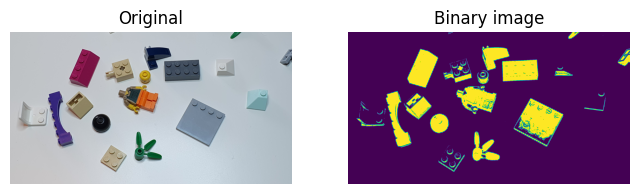

In [3]:
in_dir = 'data/'
im_org = io.imread(f'{in_dir}lego_4_small.png')
im_gray = color.rgb2gray(im_org)
thres = threshold_otsu(im_gray)
im_bin = im_gray < thres

show_comparison(im_org, im_bin, 'Binary image')

### Exercise 2

In [4]:
im_process = segmentation.clear_border(im_bin)

### Exercise 3

In [5]:
footprint = morphology.disk(5)
im_process = morphology.binary_closing(im_process, footprint)
im_open = morphology.binary_opening(im_process, footprint)

### Exercise 4

In [6]:
label_img = measure.label(im_open)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

Number of labels: 29


### Exercise 5

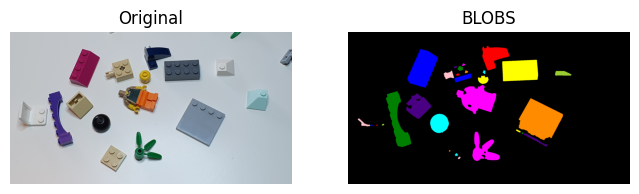

In [7]:
im_blob = label2rgb(label_img)
show_comparison(im_org, im_blob, 'BLOBS')

### Exercise 6

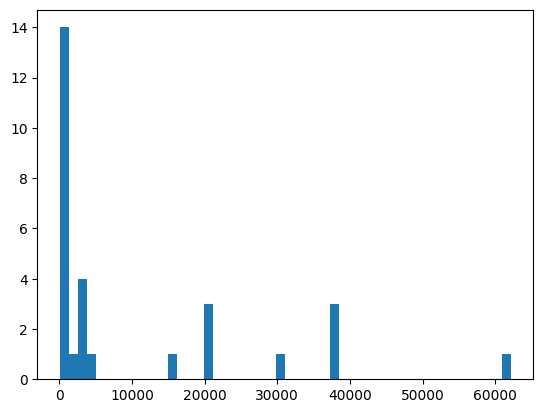

In [8]:
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=50)
plt.show()

### Exercise 7

In [10]:
!python Ex5-BlobAnalysisInteractive.py

## Cell counting

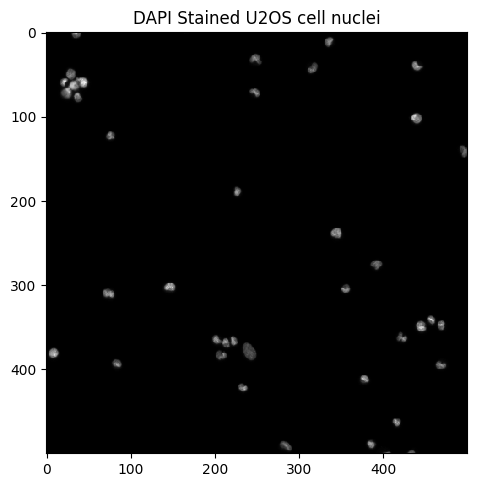

In [11]:
in_dir = "data/"
img_org = io.imread(in_dir + 'Sample E2 - U2OS DAPI channel.tiff')
# slice to extract smaller image
img_small = img_org[700:1200, 900:1400]
img_gray = img_as_ubyte(img_small) 
io.imshow(img_gray, vmin=0, vmax=150)
plt.title('DAPI Stained U2OS cell nuclei')
io.show()

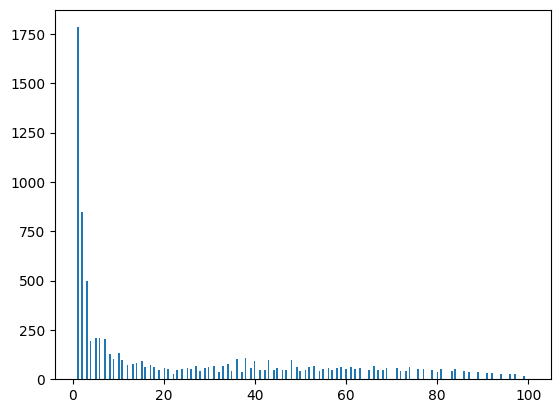

In [12]:
# avoid bin with value 0 due to the very large number of background pixels
plt.hist(img_gray.ravel(), bins=256, range=(1, 100))
io.show()

### Exercise 8

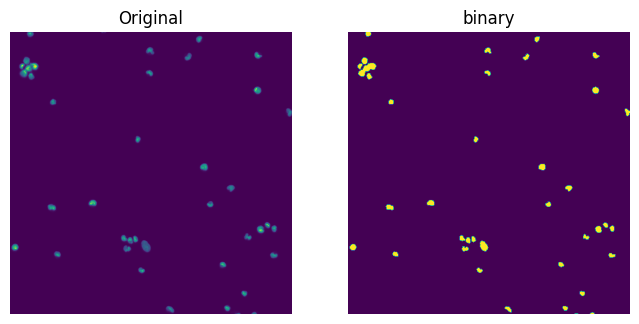

In [13]:
thres = threshold_otsu(img_gray)
img_bin = img_gray > thres
show_comparison(img_gray, img_bin, 'binary')

### Exercise 9

In [14]:
img_c_b = segmentation.clear_border(img_bin)

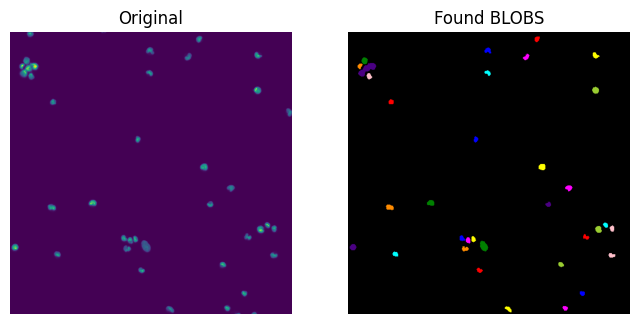

In [15]:
label_img = measure.label(img_c_b)
image_label_overlay = label2rgb(label_img)
show_comparison(img_gray, image_label_overlay, 'Found BLOBS')

### Exercise 10

In [16]:
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])

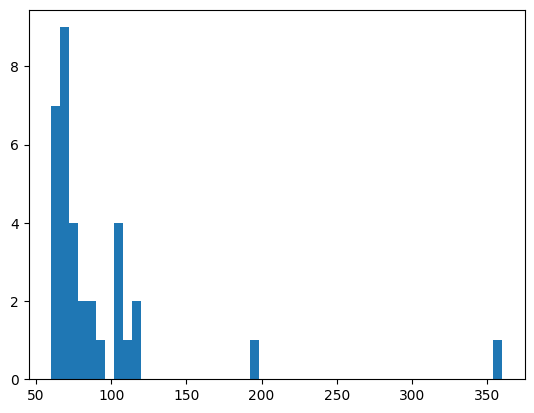

In [17]:
plt.hist(areas, bins=50)
plt.show()

### Exercise 11

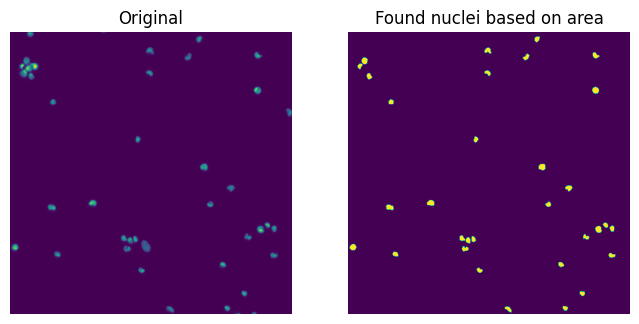

In [18]:
min_area = 10 
max_area = 150

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area')

### Exercise 12

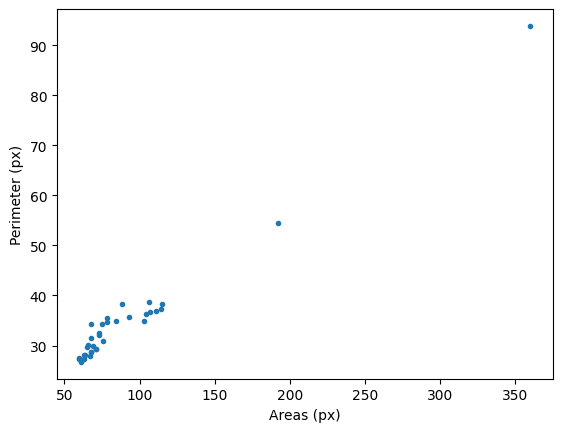

In [19]:
perimeters = np.array([prop.perimeter for prop in region_props])

fig, ax = plt.subplots(1,1)
ax.plot(areas, perimeters, '.')
ax.set_xlabel('Areas (px)')
ax.set_ylabel('Perimeter (px)')
plt.show()

### Exercise 13

In [20]:
def circularity(area, perimeter):
    '''
    You may get values larger than 1 because
    we are in a "discrete" (pixels) domain. Check:

    CIRCULARITY OF OBJECTS IN IMAGES, Botterma, M.J. (2000)
    https://core.ac.uk/download/pdf/14946814.pdf
    '''
    f_circ = (4*np.pi*area)/(perimeter**2)
    return f_circ

circs = circularity(areas, perimeters)

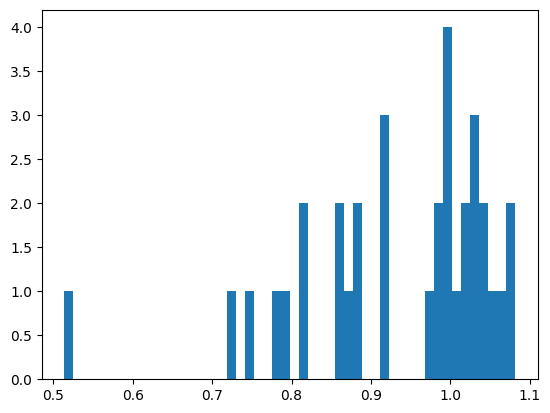

In [21]:
plt.hist(circs, bins=50)
plt.show()

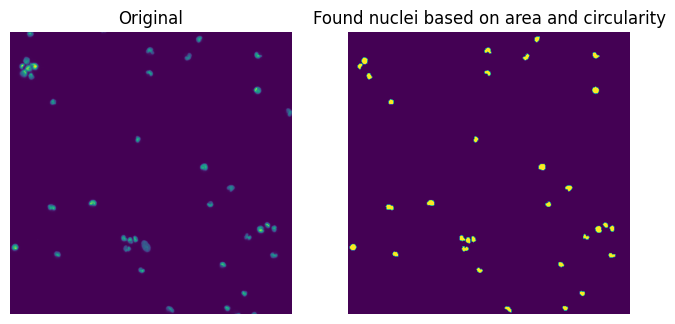

In [22]:
min_circ = 0.7
min_area = 10 
max_area = 150

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	circ = circularity(region.area, region.perimeter)
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area or circ < min_circ:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0

# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area and circularity')

### Exercise 14

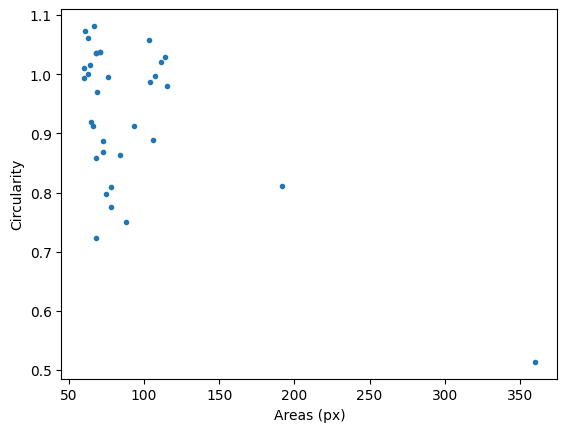

In [23]:
fig, ax = plt.subplots(1,1)
ax.plot(areas, circs, '.')
ax.set_xlabel('Areas (px)')
ax.set_ylabel('Circularity')
plt.show()

In [24]:
def cell_counting(img_gray, min_area = 10, max_area = 150, min_circ = 0.7):

    # Binarization
    thres = threshold_otsu(img_gray)
    img_bin = img_gray > thres
    img_c_b = segmentation.clear_border(img_bin)

    # Label image
    label_img = measure.label(img_c_b)

    # Extract properties
    region_props = measure.regionprops(label_img)

    # Number of blobs
    n_nuclei = len(region_props)
    
    # Filter the label image
    label_img_filter = label_img.copy()
    for region in region_props:
        circ = circularity(region.area, region.perimeter)
        # Find the areas that do not fit our criteria
        if region.area > max_area or region.area < min_area or circ < min_circ:
            # set the pixels in the invalid areas to background
            n_nuclei = n_nuclei - 1
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0

    # Create binary image from the filtered label image
    i_area = label_img_filter > 0

    return i_area, n_nuclei

### Exercise 15

In [25]:
def im2patch(im, patch_size=[256,256]):
    """
    Fancy function to rearrange an image into patches (Not important).
    
    Arguments:
        image: a 2D image, shape (r,c).
        patch size: size of extracted paches.
    Returns:
        patches: a 3D array which in every 3rd dimension has a patch associated 
    """
    
    r,c = im.shape
    s0, s1 = im.strides    
    nrows =r-patch_size[0]+1
    ncols = c-patch_size[1]+1
    shp = patch_size[0],patch_size[1],nrows,ncols
    strd = s0,s1,s0,s1

    out_view = np.lib.stride_tricks.as_strided(im, shape=shp, strides=strd)
    out_view = out_view[:,:,::patch_size[0],::patch_size[1]].reshape(patch_size[0],patch_size[1],-1)
    return out_view

In [26]:
in_dir = "data/"
img_org = io.imread(in_dir + 'Sample E2 - U2OS DAPI channel.tiff')
img_gray = img_as_ubyte(img_org)

Number of patches 24


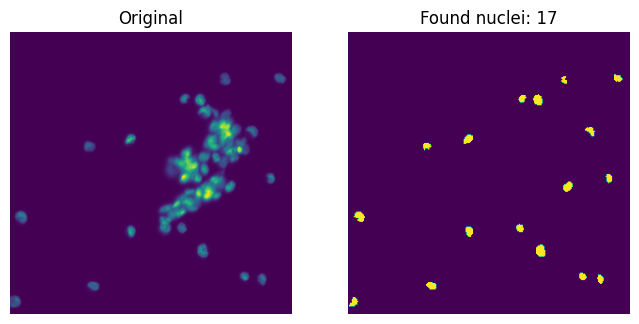

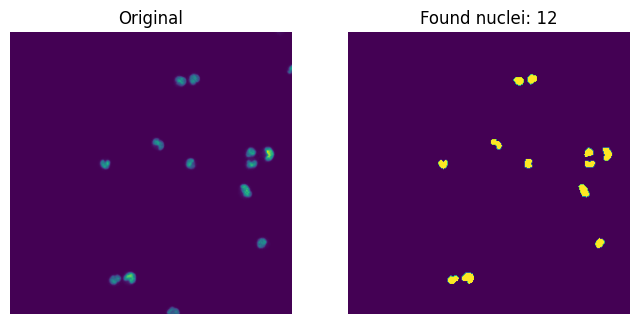

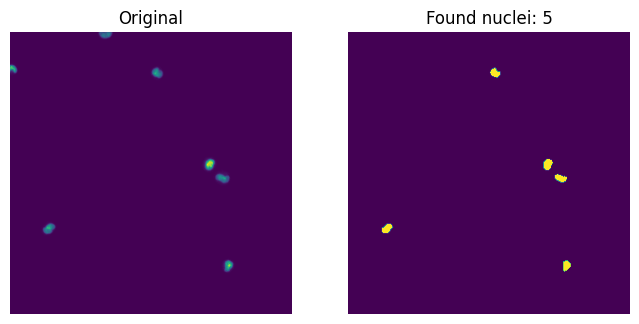

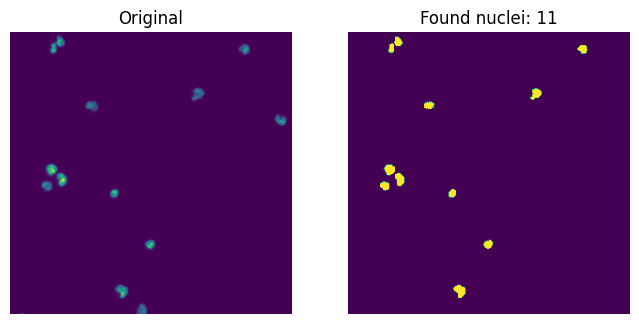

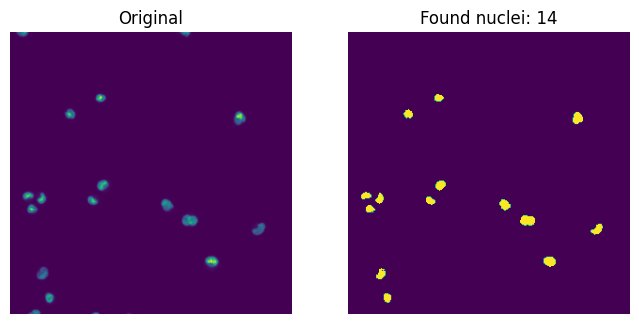

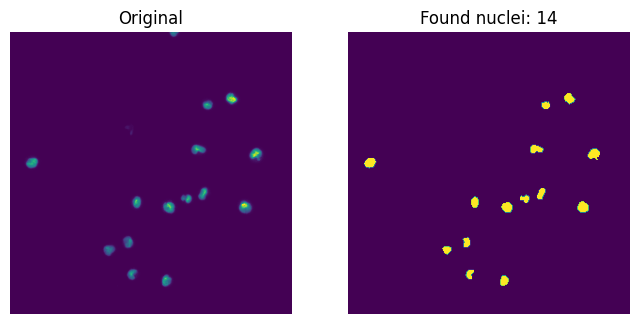

In [27]:
patches = im2patch(img_gray, patch_size=[300,300])
print(f'Number of patches {patches.shape[-1]}')

for idx_patch in range(6):
    patch = patches[:,:,idx_patch]
    filt_label, n_nuclei = cell_counting(patch)
    show_comparison(patch, filt_label, f'Found nuclei: {n_nuclei}')

### Exercise 16

Number of patches 24


C:\Users\mcbo\AppData\Local\Temp\ipykernel_5816\2868012418.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  f_circ = (4*np.pi*area)/(perimeter**2)


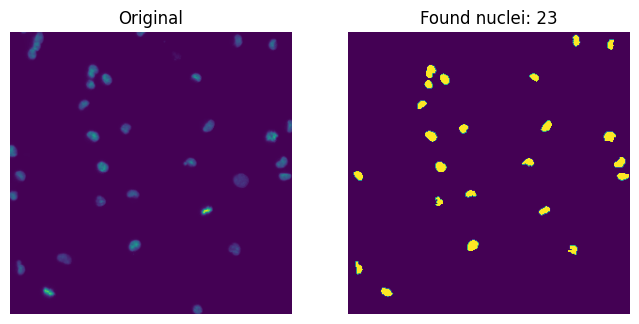

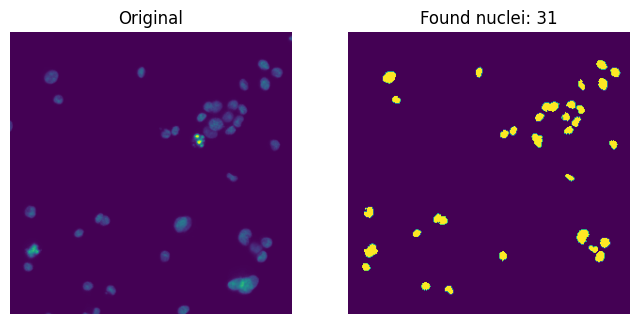

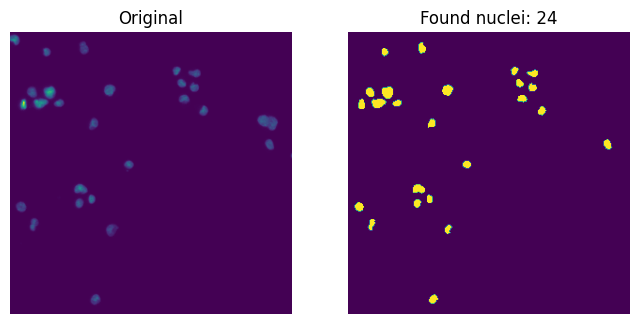

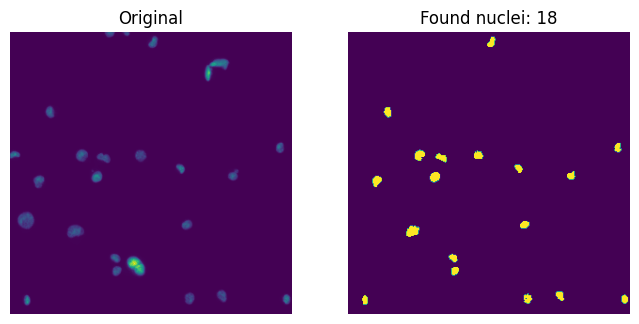

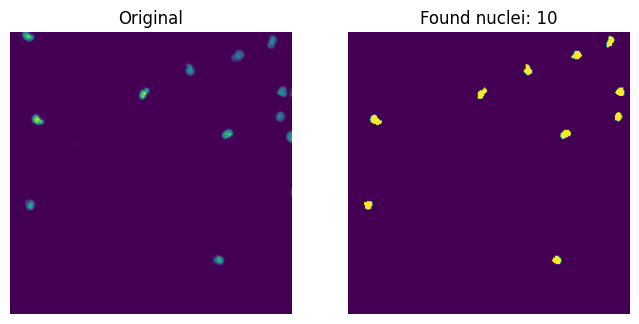

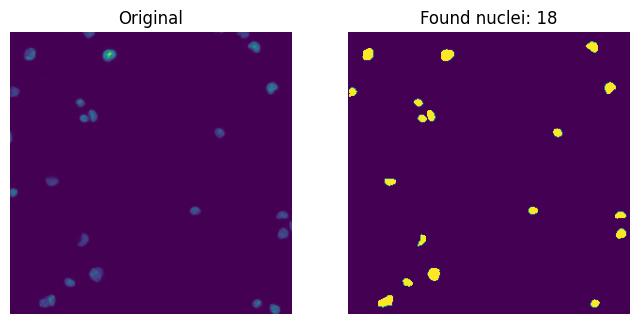

In [28]:
img_org = io.imread(in_dir + 'Sample G1 - COS7 cells DAPI channel.tiff')
img_gray = img_as_ubyte(img_org)

patches = im2patch(img_gray, patch_size=[300,300])
print(f'Number of patches {patches.shape[-1]}')

for idx_patch in range(6):
    patch = patches[:,:,idx_patch]
    filt_label, n_nuclei = cell_counting(patch)
    show_comparison(patch, filt_label,  f'Found nuclei: {n_nuclei}')

### Exercise 17

In [29]:
def cell_counting_ex17(img_gray, opening_sz = 5, min_area = 10, max_area = 150, min_circ = 0.7):

    # Binarization
    thres = threshold_otsu(img_gray)
    img_bin = img_gray > thres
    img_c_b = segmentation.clear_border(img_bin)
    img_open = morphology.binary_opening(img_c_b, morphology.disk(opening_sz))

    # Label image
    label_img = measure.label(img_open)

    # Extract properties
    region_props = measure.regionprops(label_img)
    
    # Number of blobs
    n_nuclei = len(region_props)
    
    # Filter the label image
    label_img_filter = label_img.copy()
    for region in region_props:
        circ = circularity(region.area, region.perimeter)
        # Find the areas that do not fit our criteria
        if region.area > max_area or region.area < min_area or circ < min_circ:
            n_nuclei = n_nuclei - 1
            # set the pixels in the invalid areas to background
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0

    # Create binary image from the filtered label image
    i_area = label_img_filter > 0

    return i_area, n_nuclei

Number of patches 24


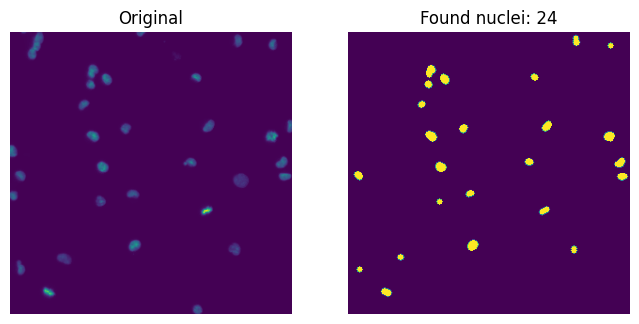

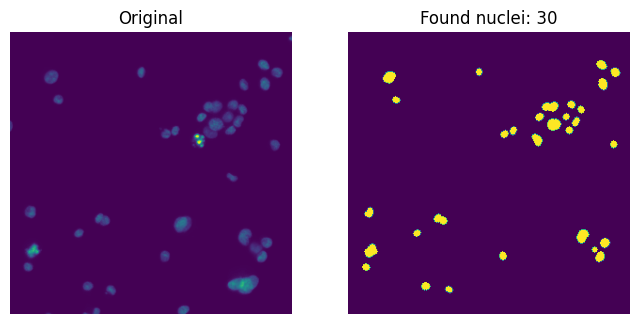

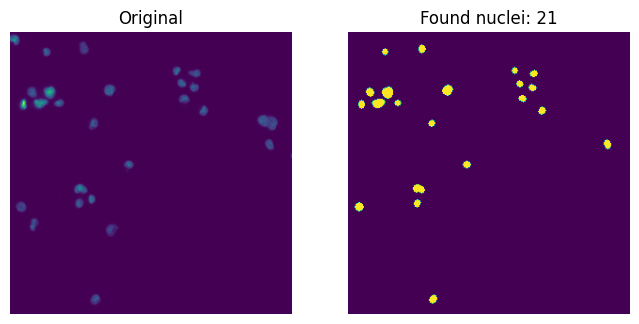

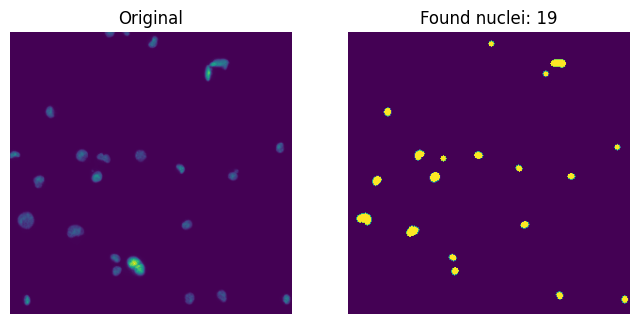

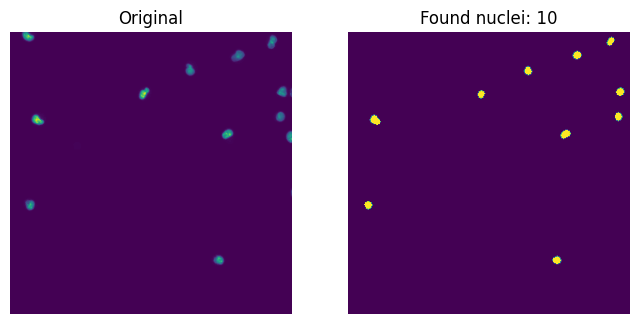

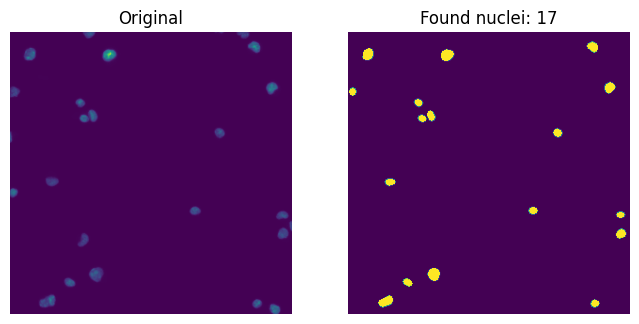

In [30]:
img_org = io.imread(in_dir + 'Sample G1 - COS7 cells DAPI channel.tiff')
img_gray = img_as_ubyte(img_org)

patches = im2patch(img_gray, patch_size=[300,300])
print(f'Number of patches {patches.shape[-1]}')

for idx_patch in range(6):
    patch = patches[:,:,idx_patch]
    filt_label, n_nuclei = cell_counting_ex17(patch, opening_sz = 3)
    show_comparison(patch, filt_label, f'Found nuclei: {n_nuclei}')